This notebook completely focuses on how to use BERT for classification. The library used is Huggingface. It is a popular library which helps us to use pre-trained transformer based architectures like BERT, T-5, RoBERTa, etc.. Here we will use tensorflow based BERT model imported from the library. 

The aim of the model will be to classify wether a comment is toxic or not. 

https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/overview

BERT has completely outperformed previous architectures. Introduction of BERT can be understood as the Inception stage of Natural Language Processing. 

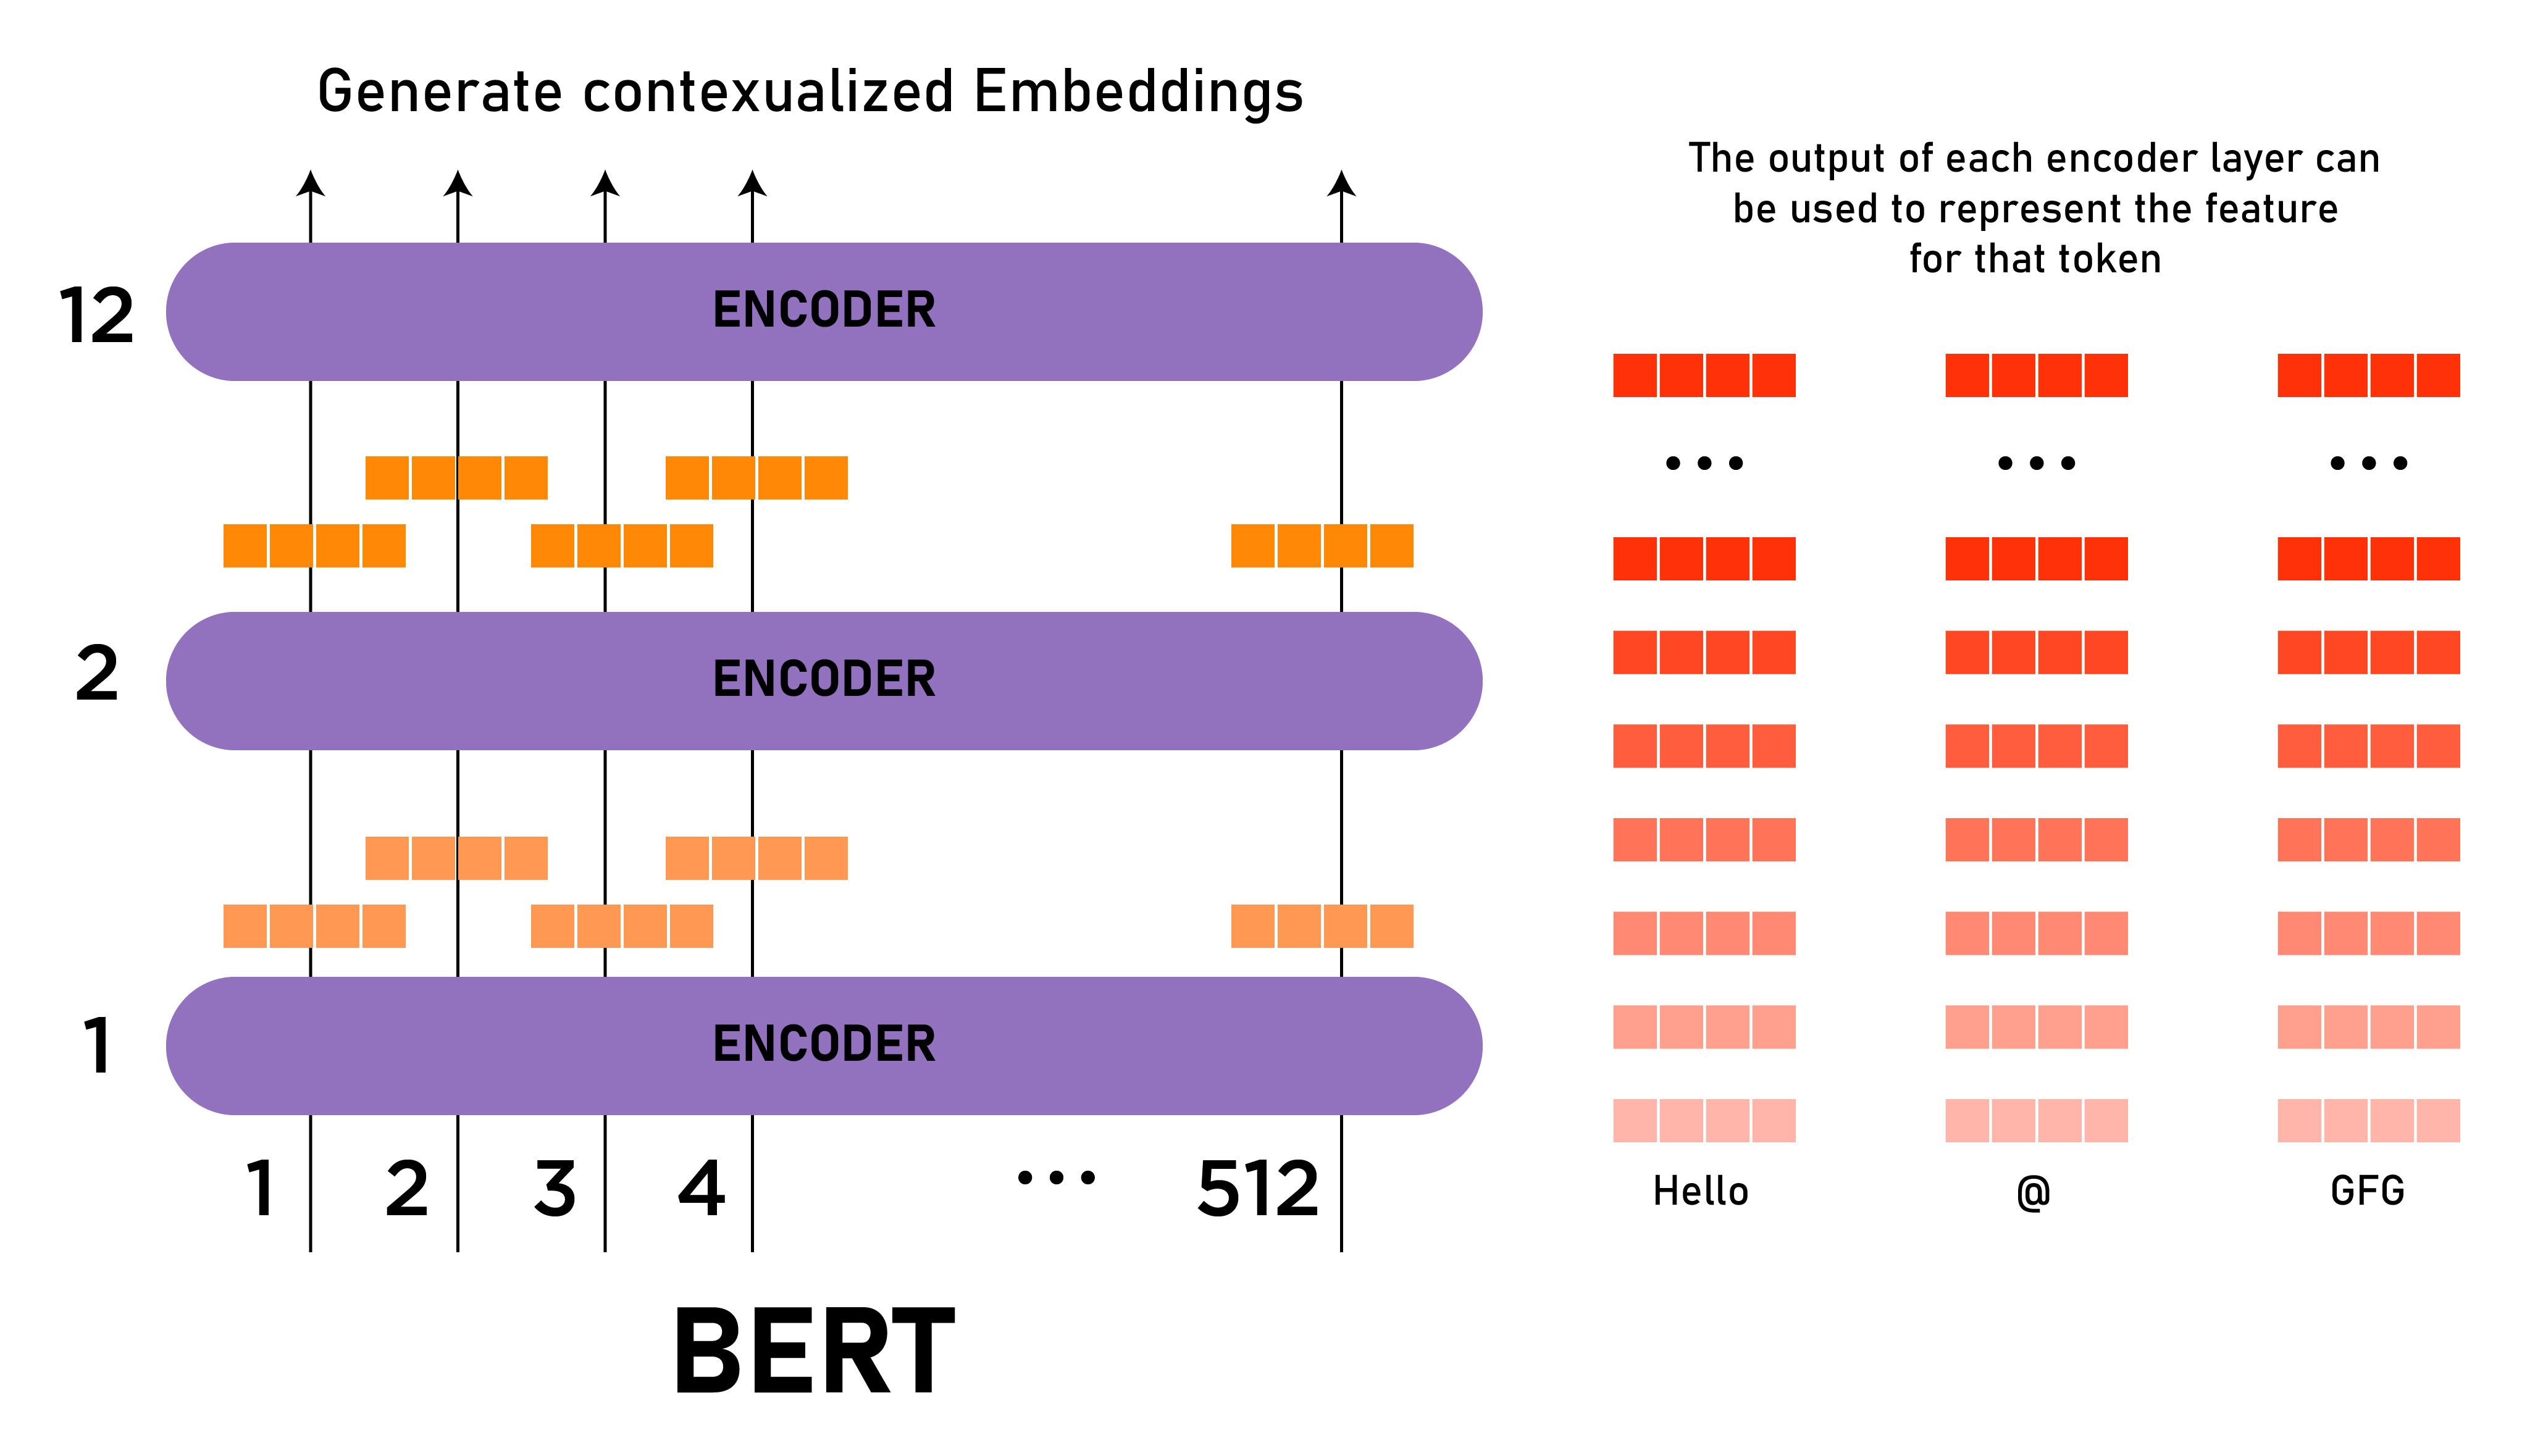

In [ ]:
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

## Helper Functions

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. This is calculated as:
![](https://miro.medium.com/max/426/1*hub04IikybZIBkSEcEOtGA.png)

Cosine Similarity calculation for two vectors A and B [source]
With cosine similarity, we need to convert sentences into vectors. One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency). The choice of TF or TF-IDF depends on application and is immaterial to how cosine similarity is actually performed — which just needs vectors. TF is good for text similarity in general, but TF-IDF is good for search query relevance.

In [ ]:
# https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt') # if necessary...


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

## TPU Configs

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('kaggle/input/') 

## Create fast tokenizer

In [ ]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

## Load text data into memory

In [ ]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

valid = pd.read_csv('/kaggle/input/val-en-df/validation_en.csv')
test1 = pd.read_csv('/kaggle/input/test-en-df/test_en.csv')
test2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [ ]:
test2.head()

## Test dataset comparision

In [ ]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.legend();

In [ ]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.xlim([0, 512])
plt.legend();

Lets calculate cosine similarity two translated test datasets.

In [ ]:
test_set_similarity = [cosine_sim(t1, t2) for t1, t2 in tqdm(zip(test1.content_en, test2.translated))]

plt.figure(figsize=(12, 8))

sns.distplot(test_set_similarity);

## Fast encode

In [ ]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_valid = fast_encode(valid.comment_text_en.astype(str), fast_tokenizer, maxlen=512)
x_test1 = fast_encode(test1.content_en.astype(str), fast_tokenizer, maxlen=512)
x_test2 = fast_encode(test2.translated.astype(str), fast_tokenizer, maxlen=512)

y_train = train1.toxic.values
y_valid = valid.toxic.values

## Build datasets objects

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(64)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(64)
    .cache()
    .prefetch(AUTO)
)

test_dataset = [(
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(64)
),
    (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(64)
)]

# Focal Loss

In [ ]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## Load model into the TPU

In [ ]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()

# LrScheduler

In [ ]:
def build_lrfn(lr_start=0.000001, lr_max=0.000002, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(35)], [_lrfn(i) for i in range(35)]);

## Train Model

In [ ]:

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=150,
    validation_data=valid_dataset,
    epochs=20,
    verbose=1
)

Clearly our model is overfitting but the point to notice here is that in just few epochs the model climbed the AUC score of 91%. This is the power of this State-of-the-Art model by Google.

# Reference


* [Original Reference](https://www.kaggle.com/miklgr500/jigsaw-tpu-bert-with-huggingface-and-keras)